## <font color='green'> <div align="center">In the name of God </div></font>

### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi</font> <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> 

# Dynamically Unfolded Hopfield with TanH on Mnist Centers in PyTorch

This code illustrates the following concepts:
 - Weight Sharing
 - Dynamic networks (here, unknown depth of network)
 - Special connections between layers

### importing general modules

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pickle

### importing PyTorch modules

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
%matplotlib inline
mpl.rcParams['figure.dpi']= 600



## Loading MNIST

In [5]:
MnistTrainX = sio.loadmat ('../../datasets/mnist/MnistTrainX')['MnistTrainX'] / 255;
MnistTrainY = sio.loadmat ('../../datasets/mnist/MnistTrainY')['MnistTrainY'];
MnistTestX  = sio.loadmat ('../../datasets/mnist/MnistTestX')['MnistTestX'] / 255;
MnistTestY  = sio.loadmat ('../../datasets/mnist/MnistTestY')['MnistTestY'];

N = 60000
MnistTrainX = np.sign (MnistTrainX[:N,:] - 0.5)
#MnistTrainY = MnistTrainY[:N,:] 

## Clustering

In [6]:
C = 10
K = 6
maxVqIteration = 100

np.random.seed(1)
filename = 'mnist_{}_clusters.pickle'.format(K)
if os.path.isfile(filename):
    with open(filename, 'rb') as file:
        centers = pickle.load(file)
else:
    clusAlg = sklearn.cluster.KMeans()
    clusAlg.max_iter = maxVqIteration
    centers = np.zeros ([C*K, dim])

    for c in range (C):
        Xi = XTrain[yTrain == c,:]
        clusAlg.n_clusters = K
        clusAlg.fit(Xi)
        for k in range(K):
            centers[c*K+k,:] = np.mean(Xi[clusAlg.labels_ == k, :],axis = 0) 
    with open(filename, 'wb') as file:
        pickle.dump(centers, file)

## Depicting Clusters

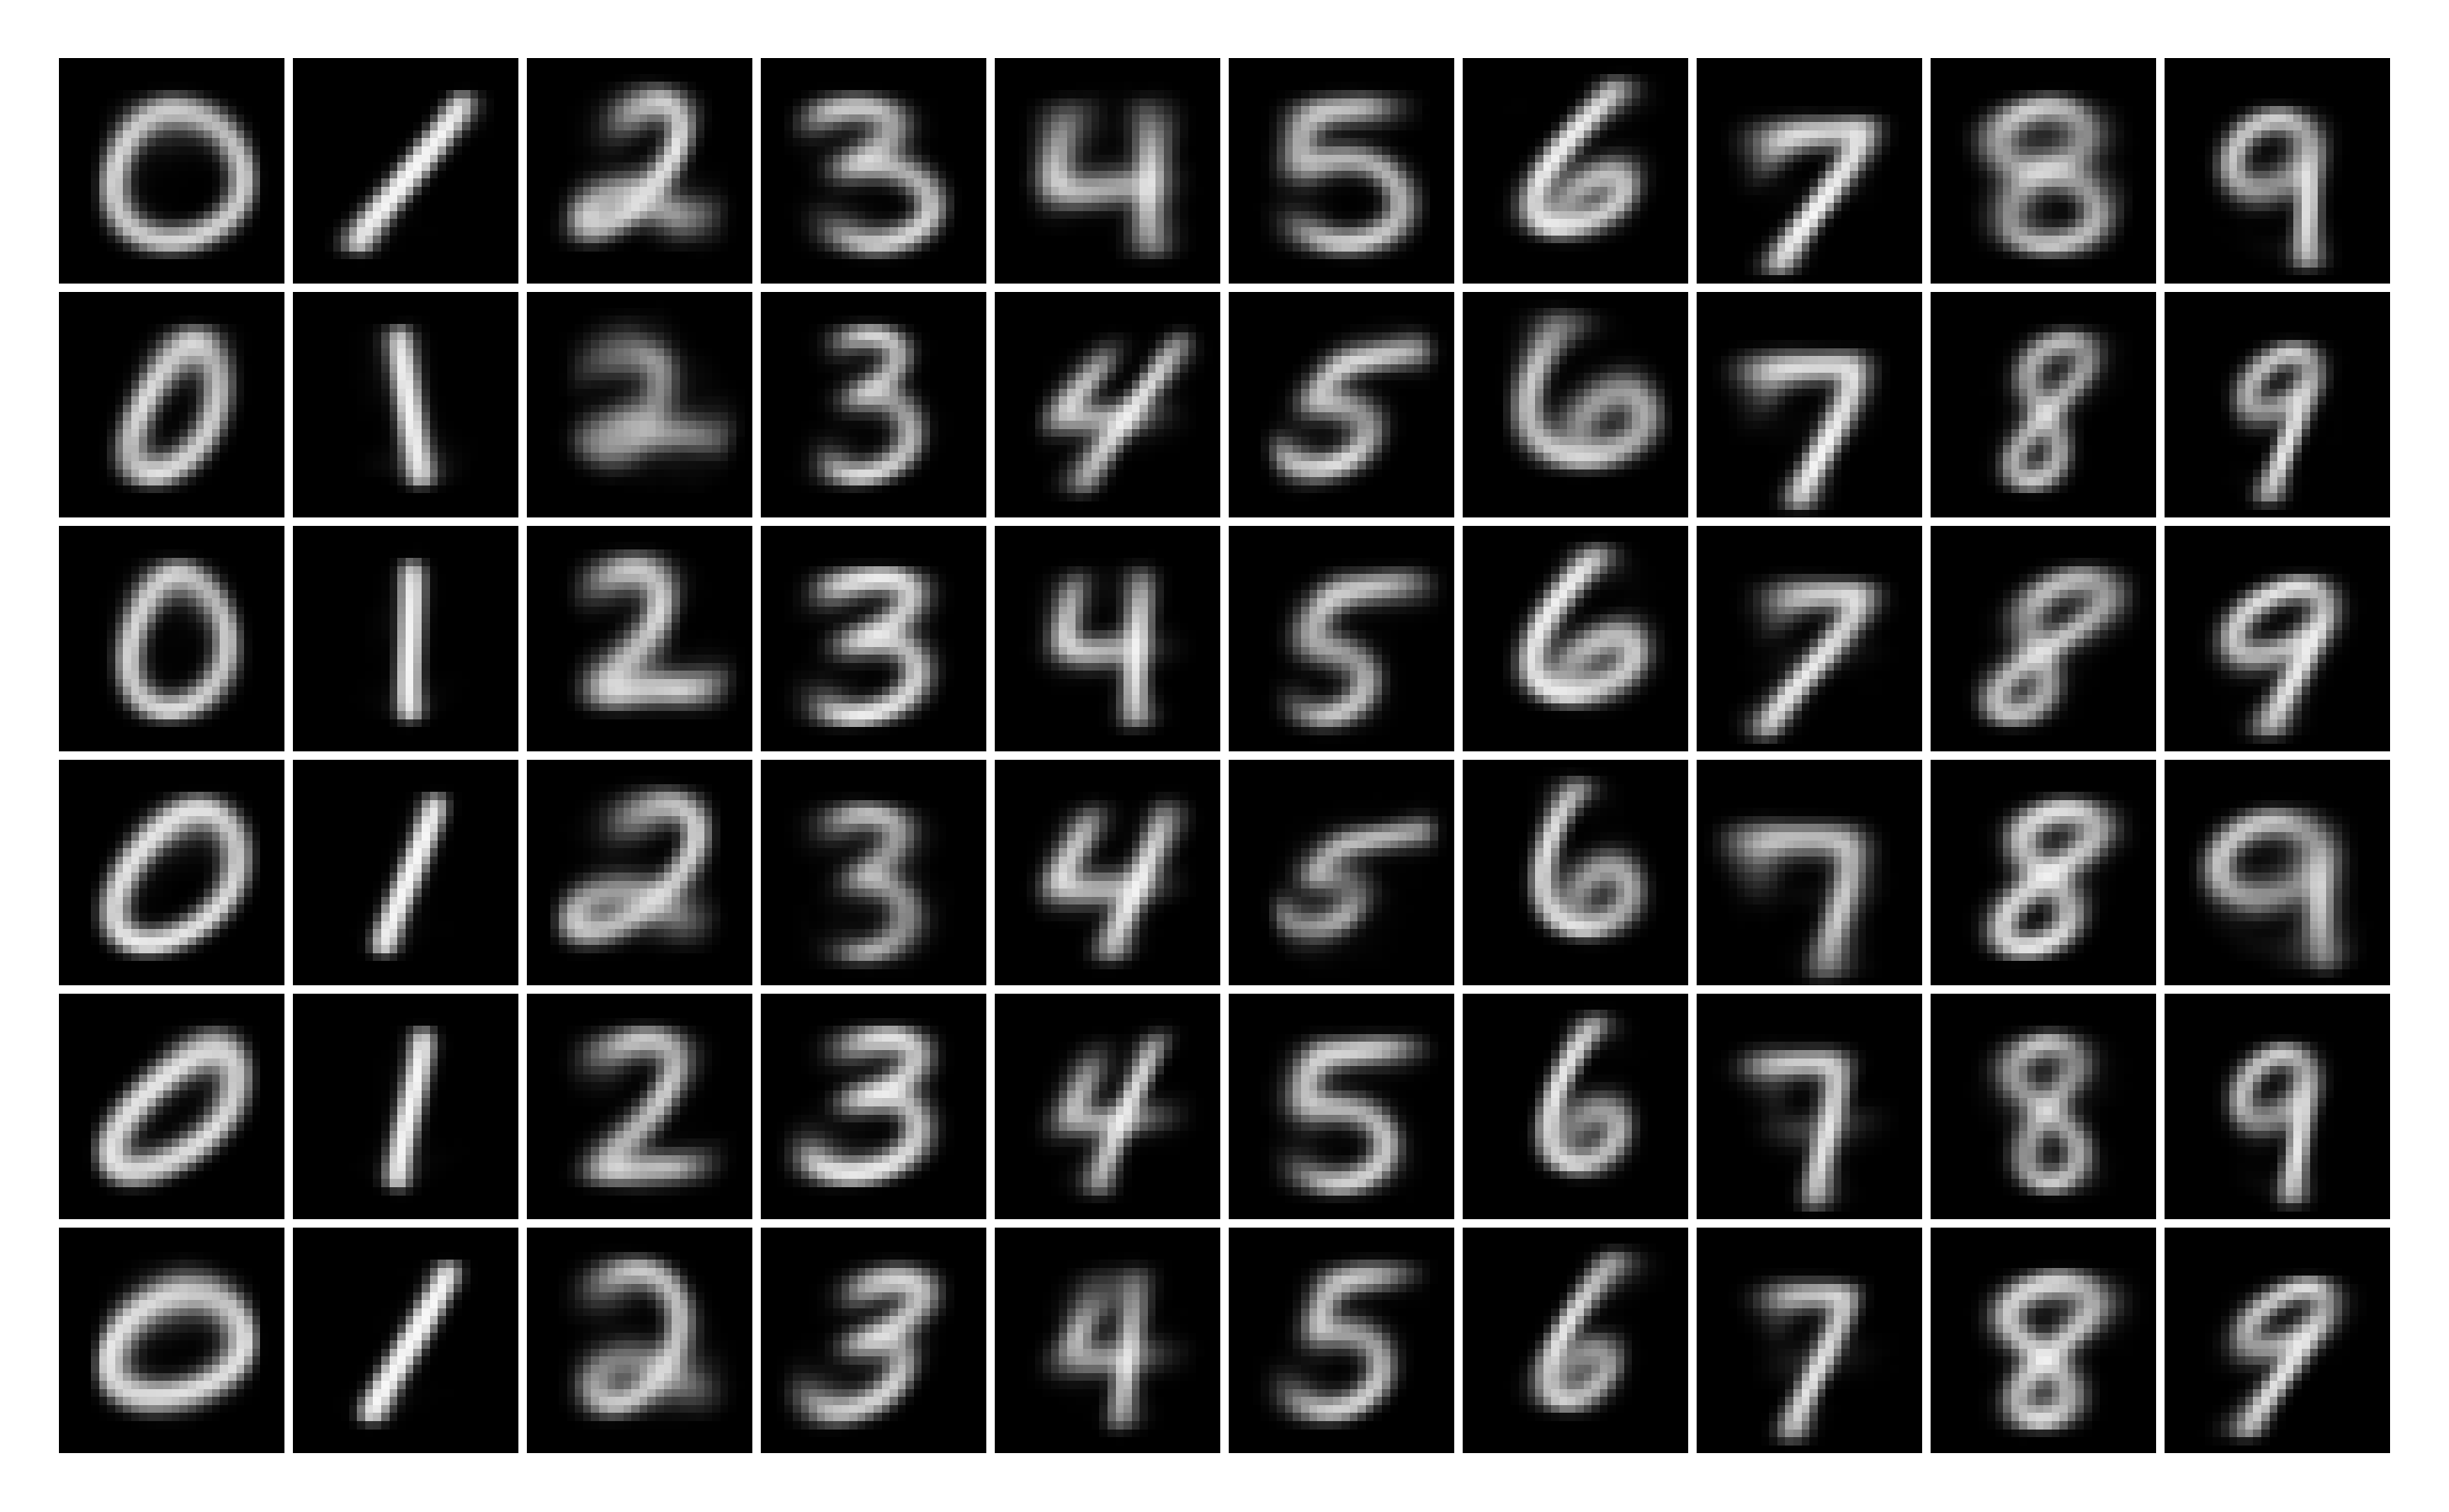

In [7]:
width = height = 28
img = np.ones ([1+K*(height+1), 1+C * (width+1),3])
for c in range(C):
    for k in range (K):
        idx1 = k*(height+1)+1
        idx2 = c*(width+1)+1
        img[idx1:idx1+height, idx2:idx2+width,0] = centers[c*K+k].reshape ([height,width])
        img[idx1:idx1+height, idx2:idx2+width,1] = img[idx1:idx1+height, idx2:idx2+width,0]
        img[idx1:idx1+height, idx2:idx2+width,2] = img[idx1:idx1+height, idx2:idx2+width,0]
plt.axis('off')
plt.imshow (img)
plt.show()

## Binarizing Clusters

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


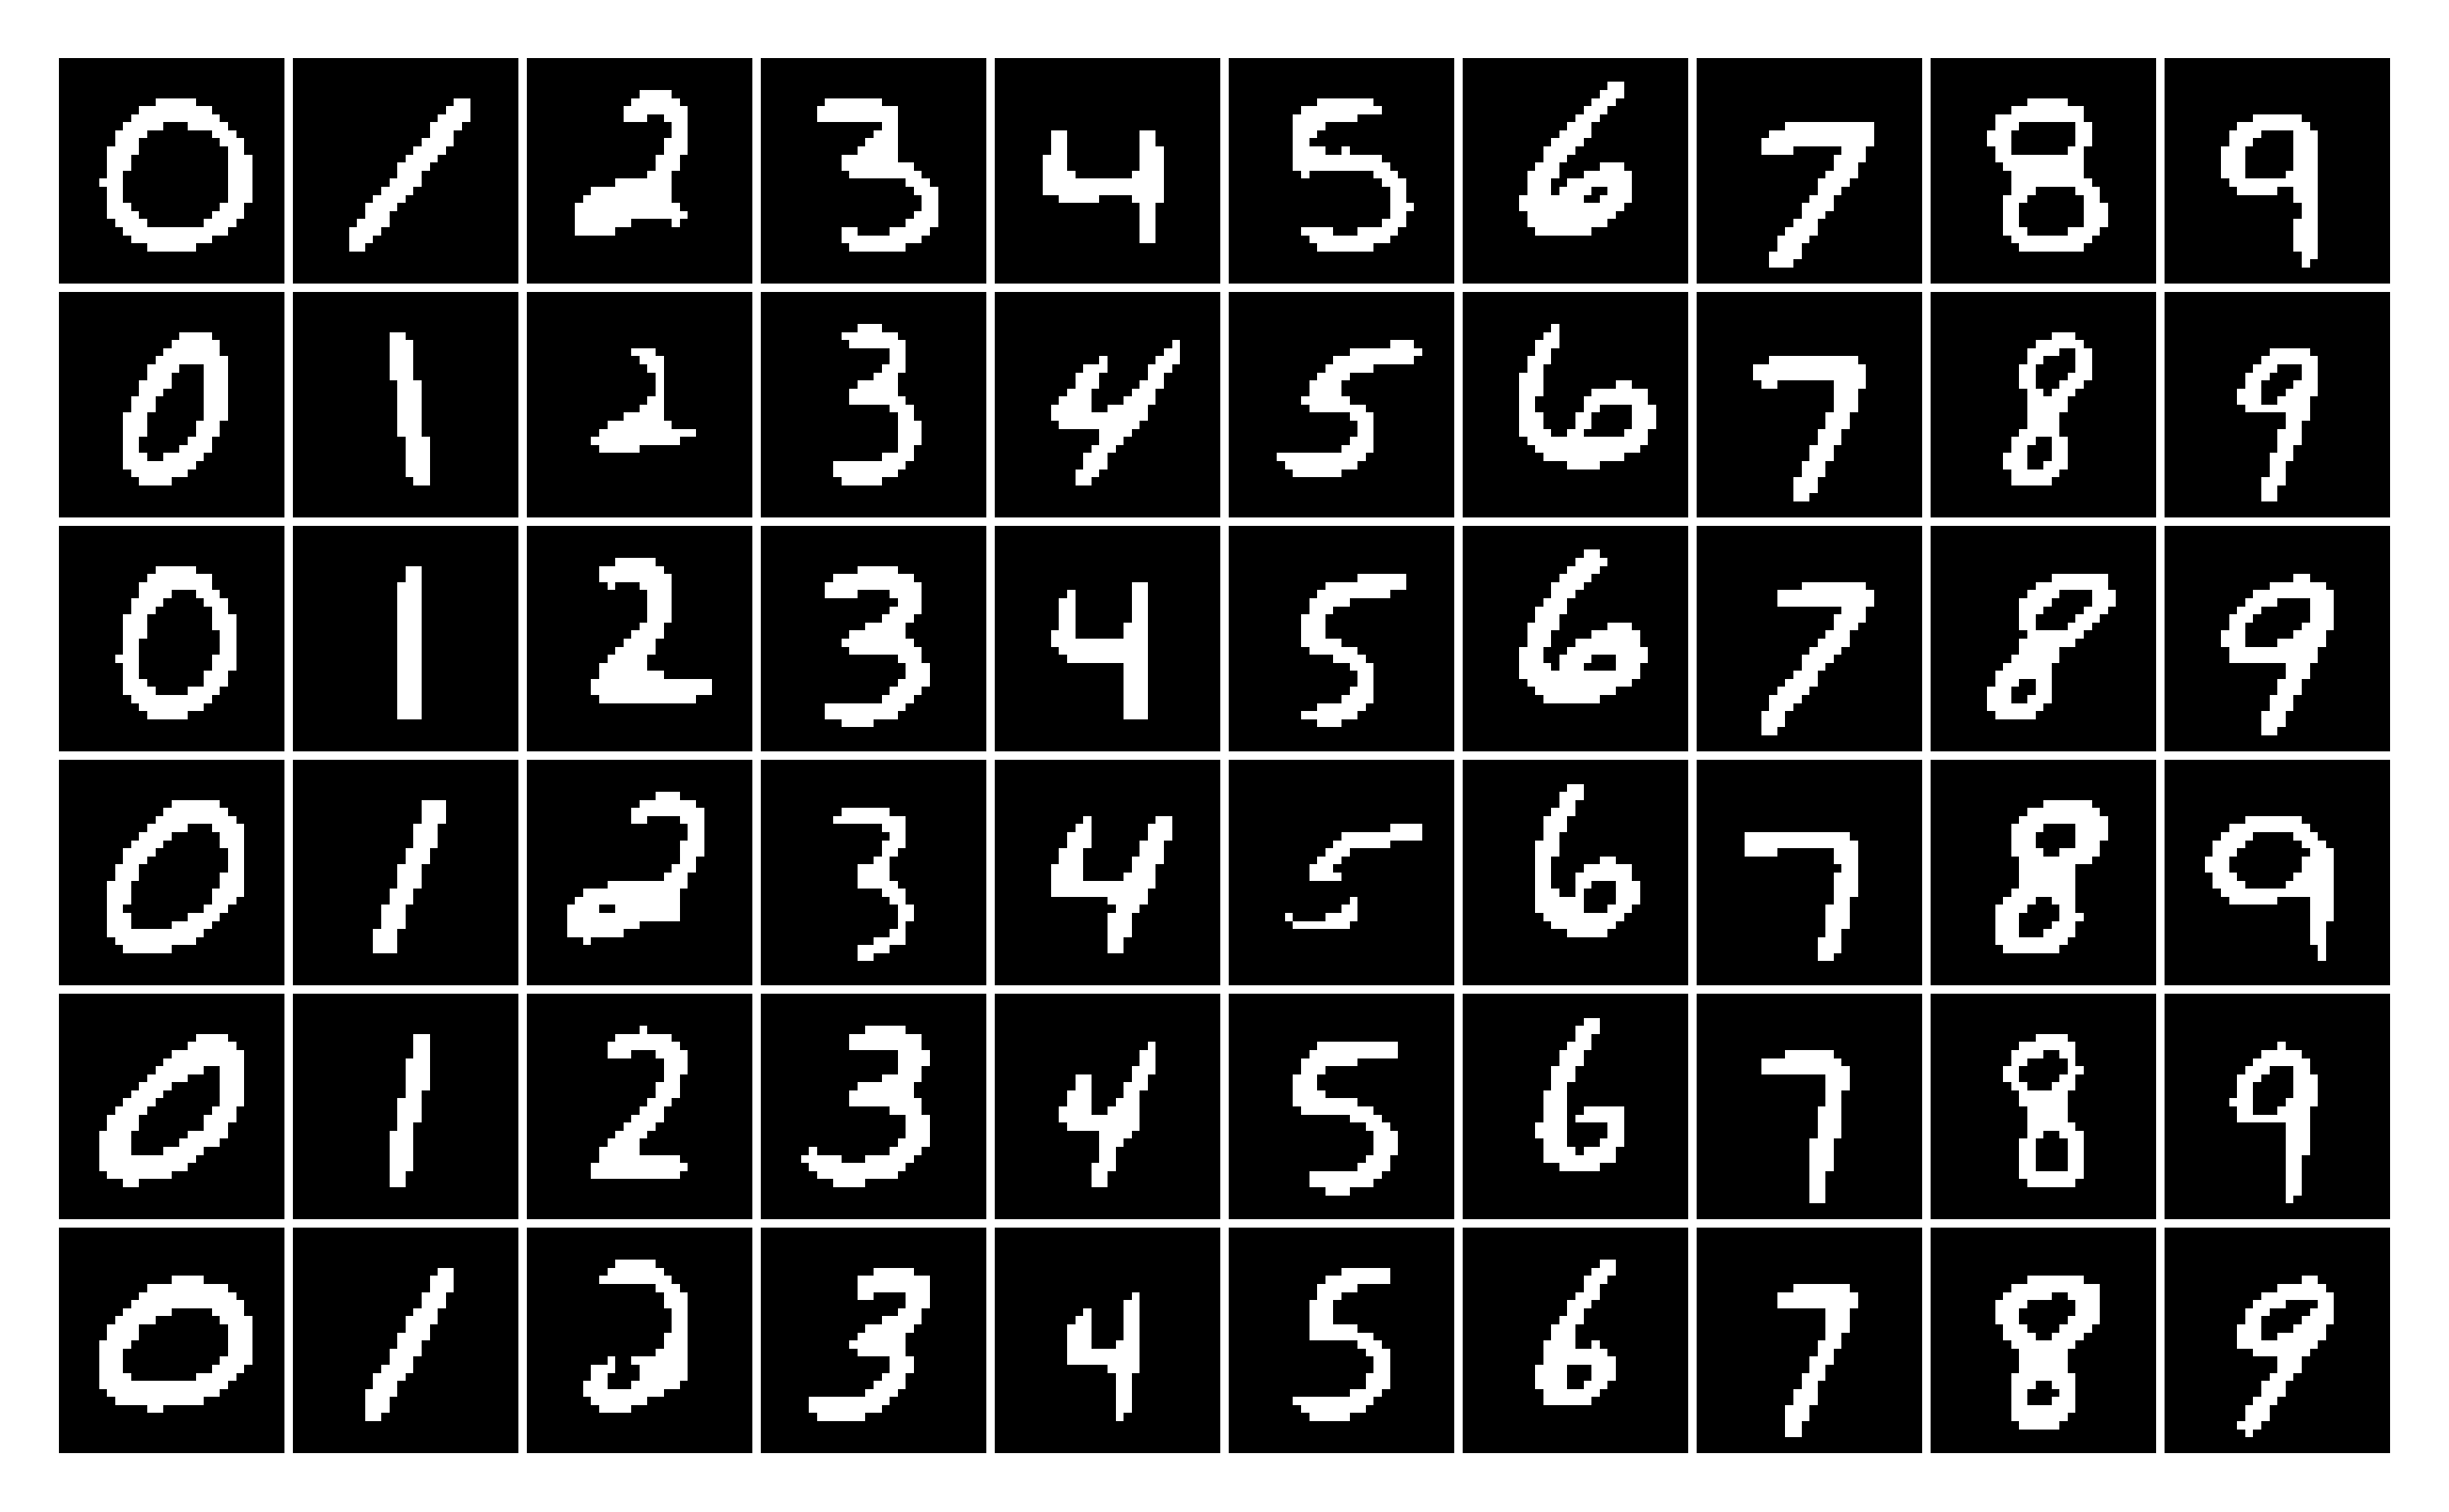

In [8]:
centers_binary = np.sign(centers-0.5)
XTest_binary = np.sign(MnistTestX - 0.5)
width = height = 28
img = np.ones ([1+K*(height+1), 1+C * (width+1),3])
for c in range(C):
    for k in range (K):
        idx1 = k*(height+1)+1
        idx2 = c*(width+1)+1
        img[idx1:idx1+height, idx2:idx2+width,0] = centers_binary[c*K+k].reshape ([height,width])
        img[idx1:idx1+height, idx2:idx2+width,1] = img[idx1:idx1+height, idx2:idx2+width,0]
        img[idx1:idx1+height, idx2:idx2+width,2] = img[idx1:idx1+height, idx2:idx2+width,0]
plt.axis('off')
plt.imshow (img)
plt.show()

## New Training Data

In [9]:
XTrain = centers_binary
N = XTrain.shape[0]

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


## Defining the UnfoldedHopfield network by inheriting from nn.Module

In [32]:
class UnfoldedHopfield(nn.Module):
    def __init__(self, num_neurons, max_unfolding):
        super().__init__()
        self.layer = nn.Linear(num_neurons, num_neurons)
        self.max_unfolding = max_unfolding
        with torch.no_grad():
            self.layer.weight.data += self.layer.weight.data.clone().t()
            self.layer.weight.data /= 2
    
    def forward(self, x):
        with torch.no_grad():
            self.layer.weight.data += self.layer.weight.data.clone().t()
            self.layer.weight.data /= 2
            for i in range (self.layer.weight.shape[0]):
                self.layer.weight[i,i] *= 0
        x_prev = x
        for i in range (self.max_unfolding):
            y = self.layer(x)
            if ((y * x > 0).byte().all() or (y * x_prev > 0).byte().all()):
                break
            elif i == self.max_unfolding - 1:
                break
            else:
                y = torch.tanh(2/3*y) * 1.7159
            x_prev = x
            x = y
        if (i > 10):
            print ('unfolding for {} layers.'.format(i))    
        return y

In [33]:
net = UnfoldedHopfield(784, 1)
print (net)

UnfoldedHopfield(
  (layer): Linear(in_features=784, out_features=784, bias=True)
)


## Optimization

In [38]:
num_epochs = 100
batch_size = 1
report_after_X_epochs = 1
learning_rate = 1
num_batches = N // batch_size

net.to(device)
optimizer = optim.SGD(net.parameters(), lr= learning_rate)
criterion = nn.BCEWithLogitsLoss()
hardSigmoid  = nn.Hardtanh(min_val=0, max_val=1) 

XTrainCuda = torch.tensor (XTrain, dtype=torch.float).to(device)
TCuda = (XTrainCuda + 1)/2


for epoch in range (num_epochs):
    for itr in range (num_batches):
        X = XTrainCuda[itr*batch_size:(itr+1)*batch_size,:]
        T = TCuda[itr*batch_size:(itr+1)*batch_size,:]
        output = net(X)
        loss = criterion(output, T)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch % report_after_X_epochs == 0):
        print('\n---- iteration #{0} of {1} at epoch #{2} of {3} ---- :'.format(
            itr, num_batches, epoch, num_epochs), end='\t')
        print('Loss = {0}'.format(loss.item()))


---- iteration #59 of 60 at epoch #0 of 10 ---- :	Loss = 0.04324374720454216

---- iteration #59 of 60 at epoch #1 of 10 ---- :	Loss = 0.04181846231222153

---- iteration #59 of 60 at epoch #2 of 10 ---- :	Loss = 0.04048388823866844

---- iteration #59 of 60 at epoch #3 of 10 ---- :	Loss = 0.03923121094703674

---- iteration #59 of 60 at epoch #4 of 10 ---- :	Loss = 0.03805278241634369

---- iteration #59 of 60 at epoch #5 of 10 ---- :	Loss = 0.03694193810224533

---- iteration #59 of 60 at epoch #6 of 10 ---- :	Loss = 0.03589283302426338

---- iteration #59 of 60 at epoch #7 of 10 ---- :	Loss = 0.034900322556495667

---- iteration #59 of 60 at epoch #8 of 10 ---- :	Loss = 0.033959854394197464

---- iteration #59 of 60 at epoch #9 of 10 ---- :	Loss = 0.033067360520362854


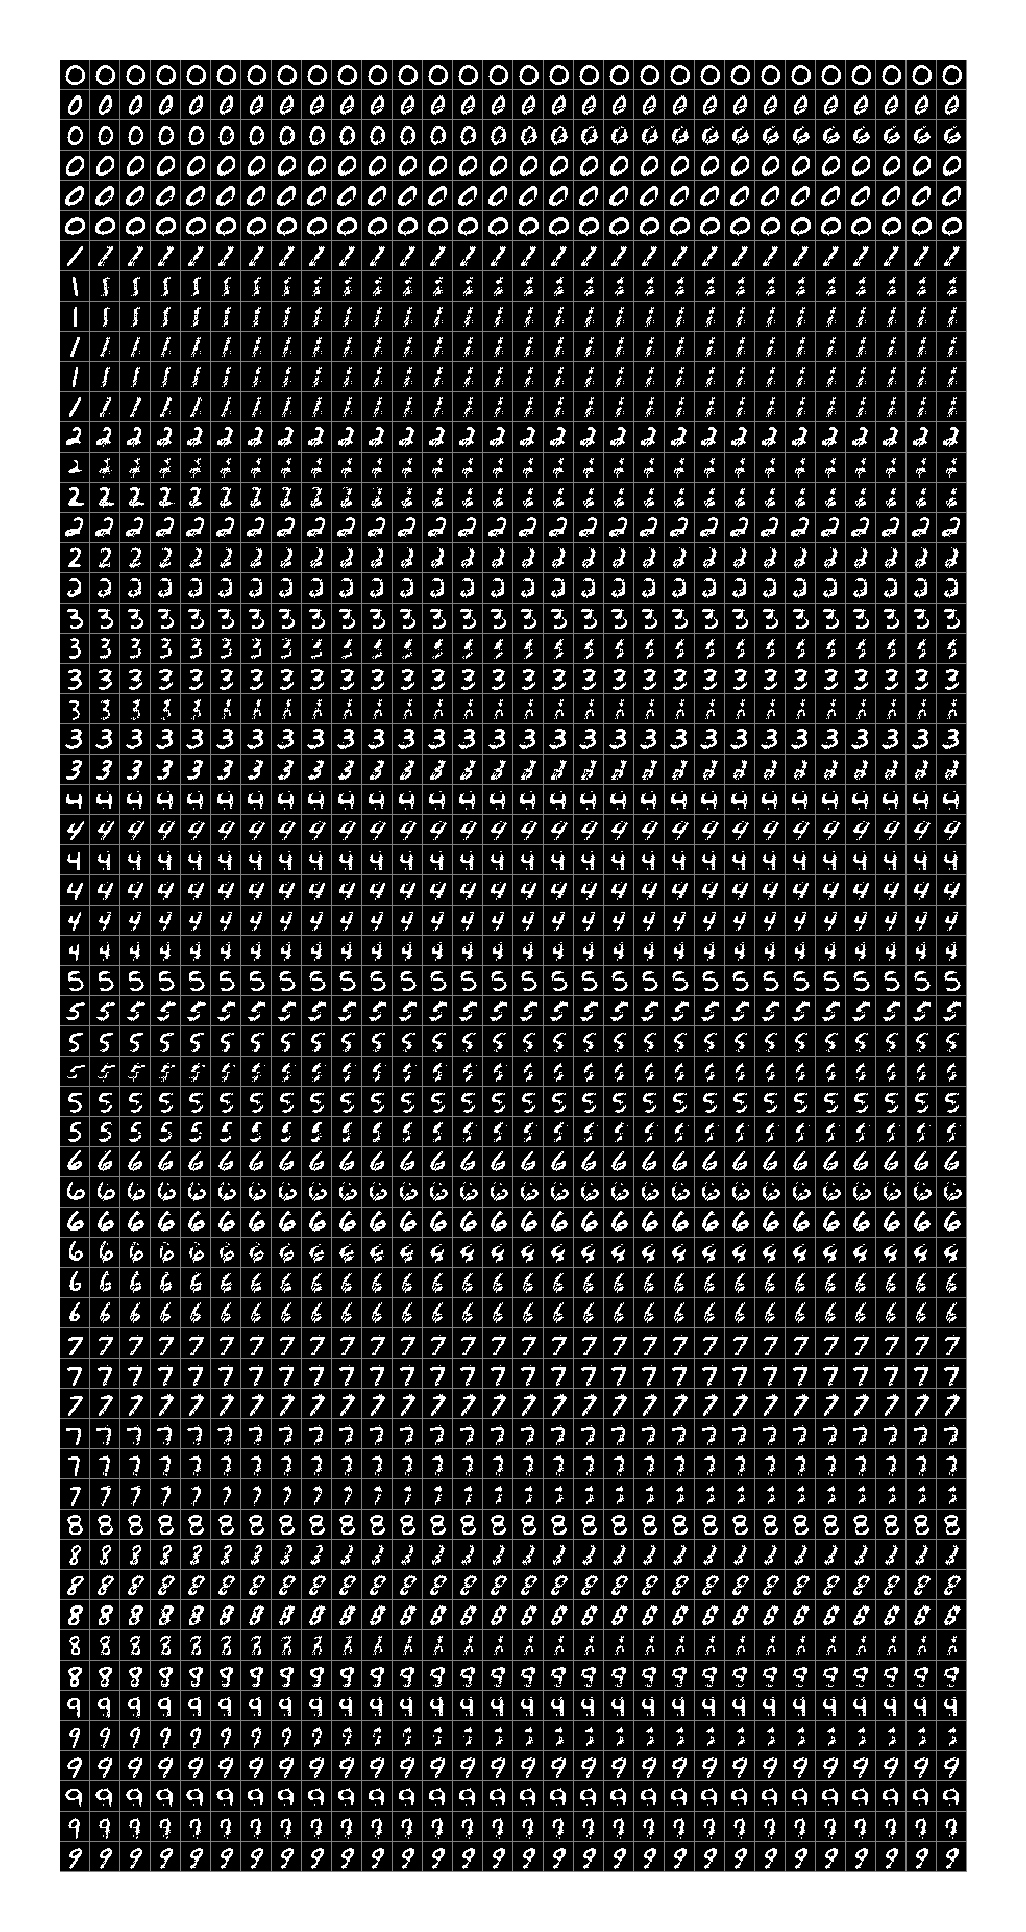

In [58]:
maxHopfieldIter = 30
NShow = 60
img = np.zeros ([29 * NShow,29 * maxHopfieldIter])
W = net.layer.weight.detach().cpu().numpy()
b = net.layer.bias.detach().cpu().numpy()
for n in range (NShow):
    x = XTrain[n,:]
    for i in range (maxHopfieldIter):
        img[n*29:n*29+28,i*29:i*29+28] = np.reshape(x,[28,28])
        z = W @ x + b
        y = np.sign(z)
        x = y
plt.axis('off')        
plt.imshow (img,cmap='gray')
plt.imsave ('hopfield_gardner_mnist.png', img,cmap='gray')
plt.show()

In [59]:
filename = 'mnist_centers_hopfield_net.pt'
if os.path.isfile(filename):
    net.load_state_dict(torch.load(filename))
else:
    torch.save(net.state_dict(), filename)

In [60]:
net_infinite = UnfoldedHopfield(784, 10000)
with torch.no_grad():
    net_infinite.layer.weight.data = net.layer.weight.data.clone()
    net_infinite.layer.bias.data = net.layer.bias.data.clone()
print (net_infinite)
net_single = net
net = net_infinite

UnfoldedHopfield(
  (layer): Linear(in_features=784, out_features=784, bias=True)
)


In [61]:
num_epochs = 20
batch_size = 1
report_after_X_epochs = 1
learning_rate = 0.01
num_batches = N // batch_size

net.to(device)
optimizer = optim.SGD(net.parameters(), lr= learning_rate)
criterion = nn.BCEWithLogitsLoss()
hardSigmoid  = nn.Hardtanh(min_val=0, max_val=1) 

XTrainCuda = torch.tensor (XTrain, dtype=torch.float).to(device)
TCuda = (XTrainCuda + 1)/2


for epoch in range (num_epochs):
    for itr in range (num_batches):
        X = XTrainCuda[itr*batch_size:(itr+1)*batch_size,:]
        T = TCuda[itr*batch_size:(itr+1)*batch_size,:]
        output = net(X)
        loss = criterion(output, T)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch % report_after_X_epochs == 0):
        print('\n---- epoch #{0} of {1} ---- :'.format(epoch, num_epochs), end='\t')
        print('Loss = {0}'.format(loss.item()))

unfolding for 11 layers.
unfolding for 16 layers.
unfolding for 11 layers.

---- iteration #59 of 60 at epoch #0 of 20 ---- :	Loss = 0.017404142767190933
unfolding for 17 layers.
unfolding for 15 layers.
unfolding for 11 layers.
unfolding for 11 layers.

---- iteration #59 of 60 at epoch #1 of 20 ---- :	Loss = 0.018698353320360184
unfolding for 17 layers.
unfolding for 12 layers.
unfolding for 11 layers.
unfolding for 11 layers.

---- iteration #59 of 60 at epoch #2 of 20 ---- :	Loss = 0.020497754216194153
unfolding for 13 layers.
unfolding for 12 layers.

---- iteration #59 of 60 at epoch #3 of 20 ---- :	Loss = 0.022885655984282494
unfolding for 14 layers.
unfolding for 11 layers.
unfolding for 14 layers.

---- iteration #59 of 60 at epoch #4 of 20 ---- :	Loss = 0.022942734882235527

---- iteration #59 of 60 at epoch #5 of 20 ---- :	Loss = 0.022906098514795303
unfolding for 12 layers.
unfolding for 11 layers.

---- iteration #59 of 60 at epoch #6 of 20 ---- :	Loss = 0.0204809103161096

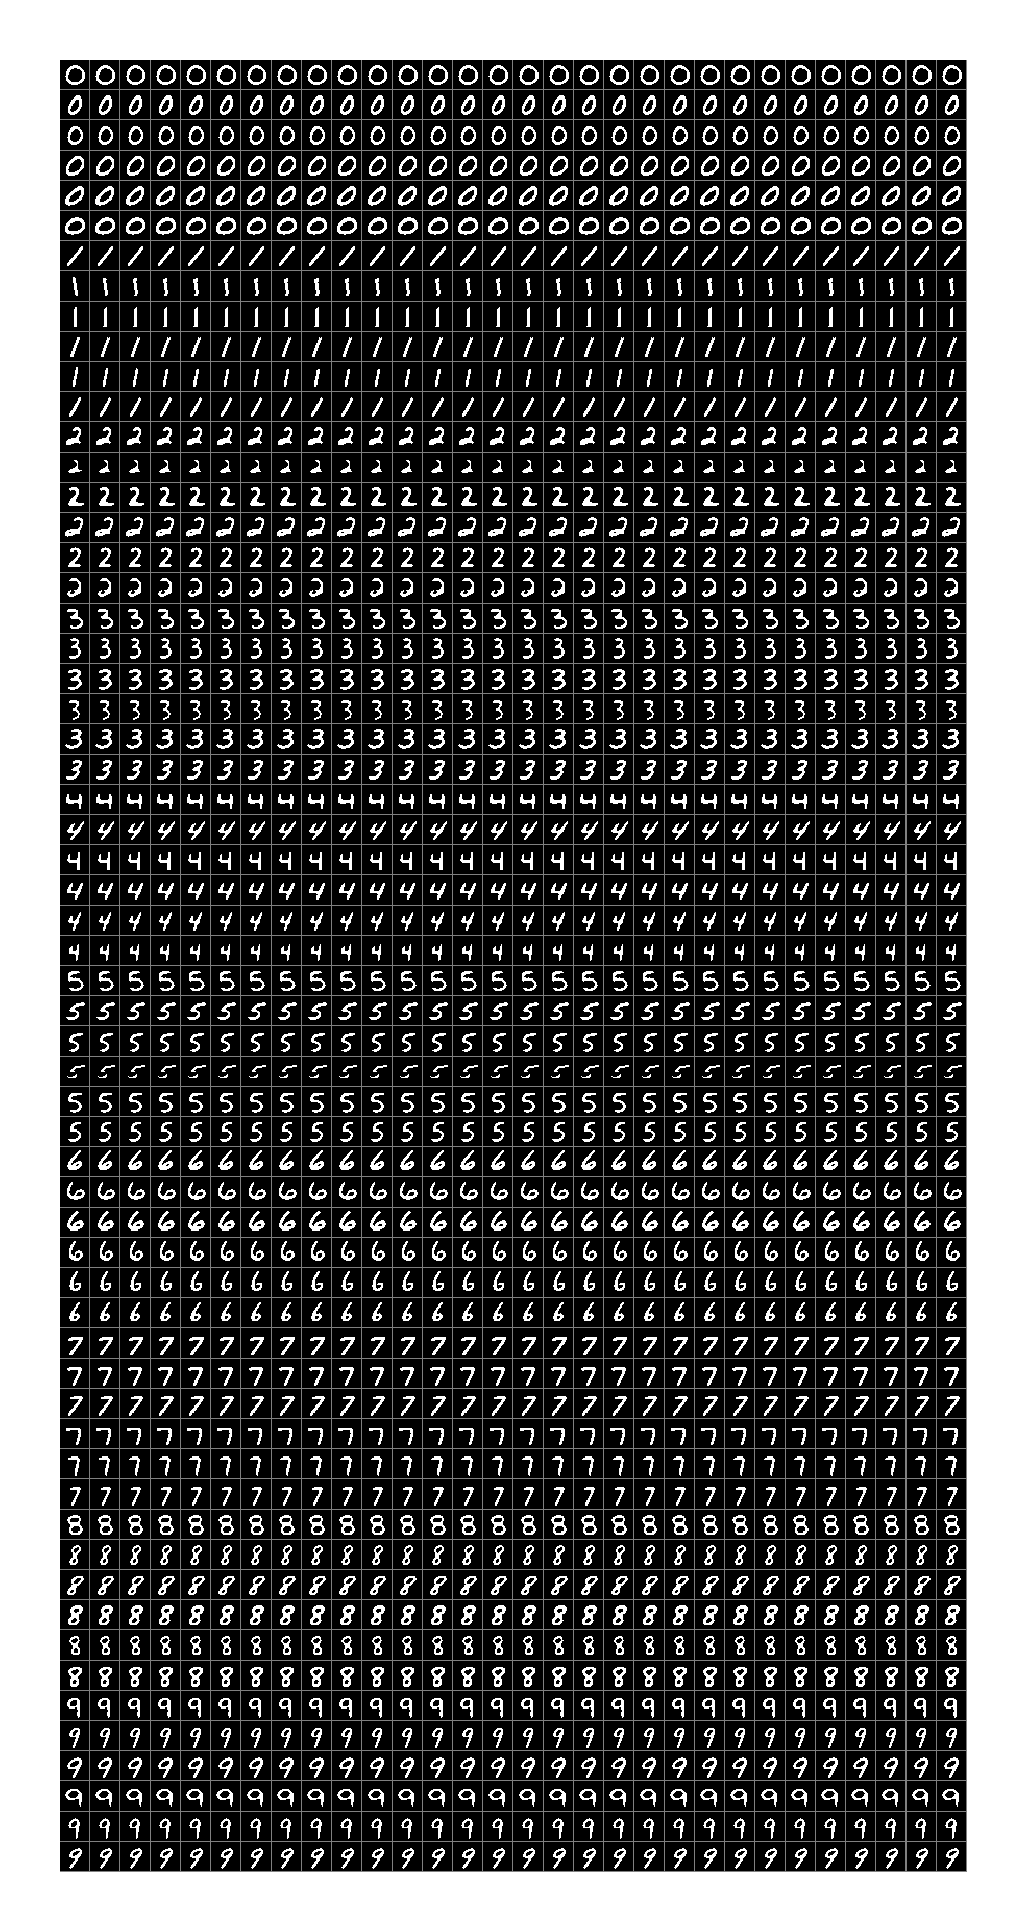

In [62]:
maxHopfieldIter = 30
NShow = 60
img = np.zeros ([29 * NShow,29 * maxHopfieldIter])
W = net.layer.weight.detach().cpu().numpy()
b = net.layer.bias.detach().cpu().numpy()
for n in range (NShow):
    x = XTrain[n,:]
    for i in range (maxHopfieldIter):
        img[n*29:n*29+28,i*29:i*29+28] = np.reshape(x,[28,28])
        z = W @ x + b
        y = np.sign(z)
        x = y
plt.axis('off')        
plt.imshow (img,cmap='gray')
plt.imsave ('hopfield_gardner_mnist.png', img,cmap='gray')
plt.show()